In [1]:
#import matplotlib
#matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import random
import pandas as pd
import cv2




from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from functools import lru_cache
import numpy as np
from scipy import ndimage

In [2]:
flatten = lambda l: [item for sublist in l for item in sublist]

def frames():
    vidcap = cv2.VideoCapture('../data/train.mp4')
    while True:
        success, image = vidcap.read()
        if success:
            yield image
        else:
            return

def crop(im, bottom=100, top=220):
    # take of top and bottom
    return im[top:im.shape[0]-bottom,:]

def tile(im, nrows=1, ncolumns=6):
    M = im.shape[0] // nrows
    N = im.shape[1] // ncolumns
    rows = []
    for y in range(0,N*ncolumns,N):
        row = []
        for x in range(0,M*nrows,M):
            row.append(im[x:x+M,y:y+N])
        rows.append(row)
    return rows

def shuffle_time_in_chunks(df, n):
    """Break df into n-lengths mini dfs"""
    assert len(df) > n*10, "doesn't meet minimum number of chunks"
    assert (len(df) % n) == 0, "all chunks equal size"

    chunk_count = len(df[0]) // n
    chunks = []
    for x in range(0, len(df), n):
        chunks.append(df[x:x + n])
    random.shuffle(chunks)
    return pd.concat(chunks, axis=0)

def quick_view(fs, frames_per_step=1, start=1000, stop=1010):
    for i, im in enumerate(fs):
        if not (start<i<stop):
            if i>stop:
                break
            continue
        if i % frames_per_step != 0:
            continue
        cv2.imshow('oned',im)
        try:
            cv2.waitKey(0)
        except KeyboardInterrupt:
            cv2.destroyAllWindows()
            break
    cv2.destroyAllWindows()

In [3]:
def cframes():
    for im in frames():
        yield crop(im)

In [4]:
#quick_view(cframes(), frames_per_step=1, start=60, stop=180)

In [5]:
cv2.destroyAllWindows()

282.0 4.0 281.98434 4.104451
228.0 1.0 228.06407 1.2504716
254.0 2.0 254.02345 2.0673227
370.0 9.0 370.4765 9.151665
203.0 4.0 203.34843 4.182705
322.0 4.0 322.0129 4.0694537


<ipython-input-26-bcba1ad67d68>:28: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mask = cv2.arrowedLine(mask, (a,b),(c,d), 255, tipLength=.3)
<ipython-input-26-bcba1ad67d68>:29: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mask = cv2.circle(mask,(a,b),2,255, -1)


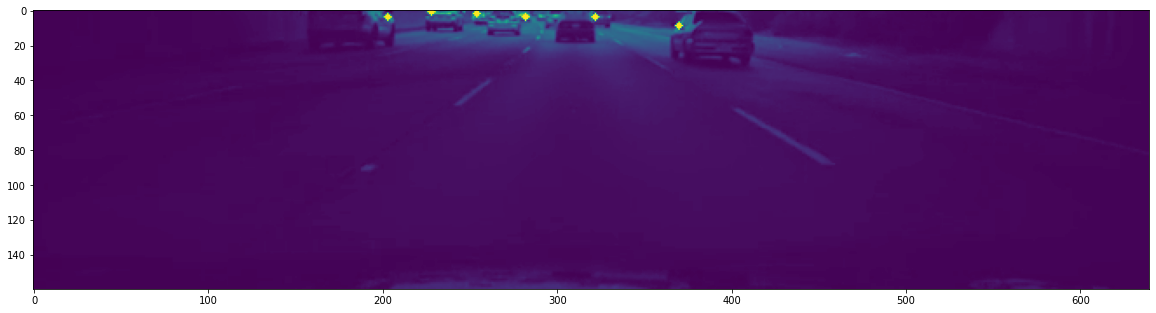

done
fin


In [26]:
def via_lk(im, last_im):
    # params for ShiTomasi corner detection
    feature_params = dict(maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 20,
                       blockSize = 7 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                      maxLevel = 2,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    p0 = cv2.goodFeaturesToTrack(last_im, mask = None, **feature_params)
    p1, st, err = cv2.calcOpticalFlowPyrLK(last_im, im, p0, None, **lk_params)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(last_im)
    
    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = old.ravel()
        c,d = new.ravel()
        print(a,b,c,d)
        mask = cv2.arrowedLine(mask, (a,b),(c,d), 255, tipLength=.3)
        mask = cv2.circle(mask,(a,b),2,255, -1)

    img = cv2.add(im,mask)
    plt.rcParams['figure.figsize'] = [20, 12]
    plt.imshow(img)
    plt.show()
    print("done")
    return 0    



xs=[]
last_im = None
for i, im in enumerate(cframes()):
    im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    if last_im is None:
        last_im = im
    
    if ((i+1) % 100) == 0:
        print('.', end='')
        break
    if i == 32:
        via_lk(im,last_im)
        break
      
    last_im = im
print('fin')

In [14]:
cv2.destroyAllWindows()

https://www.google.com/search?channel=fs&client=ubuntu&q=linetesting error, training error
- naive shuffle, mean dummy regressor = 68
- naive shuffle, 1x1x(varlaplace) tilessvr.predict(Xtest), SVR(C=?) = 44
- naive shuffle, 6x3x(varlaplace) tiles, SVR(C=30) = 19.4
- naive shuffle, 12x5x(varlaplace) tiles, SVR(C=30) = 10.3
- naive shuffle, test_size=.150, 26x12x(varlaplace) tiles, SVR(C=.2) = 17.9, 18.1
-    no shuffle, test_size=.150, 26x12x(varlaplace) tiles, SVR(C=.2) = 33.2, 17.7
- chunk shuffle, test_size=.147, 26x12x(varlaplace) tiles, SVR(C=.2) = 39, 16.6
- chunk shuffle, test_size=.147, 26x12x(varlaplace) tiles, SVR(C=.1) = 42, 20
- chunk shuffle, test_size=.147, 26x12x(varlaplace) tiles, SVR(C=.5) = 36, 12
- chunk shuffle, test_size=.147, 14x06x(varlaplace) tiles, SVR(C=.5) = 27, 19
- chunk shuffle, test_size=.147, 14x06x(varlaplace) tiles, SVR(C=.3) = 28.5, 21.5, 39.5
- chunk shuffle, test_size=.245, 14x06x(varlaplace) tiles, SVR(C=.3) = 50, 46, 18
# new crop
- chunk no shuffle, test_size=.245, 14x06x(varlaplace) tiles, SVR(C=.3) = 71, 39, 26.9
- chunk=5 shuffle, test_size=.367, 06x06x(varlaplace) tiles, SVR(C=.3) = 67, 30, 29.1
- chunk=5 shuffle, test_size=.491, 06x06x(varlaplace) tiles, SVR(C=.3) = 67, 30, 29.7
- chunk=5 shuffle, test_size=.73, 06x06x(varlaplace) tiles, SVR(C=.3) = 67, 32, 30.7

# Fixed tiler test_pct=.43                                             
-                                                                 dummy test train test_kf
- chunk=60 focus(4x10), SVR(C=.3) = 70.3 39.6 29.4
- chunk=60 focus(4x10), SVR(C=.3) = 71.6 31.1 22.6
- chunk=60 focus(4x10), test_size=.43, 8x20(varlaplace), gridsearch = 71.6 31.1 22.6

# add gridsearch, cv, standard scaler test_pct=.43  
- chunk=60 focus(3x3),  SVR(C=20, gamma=0.006) 64.0 13.0 2.0
- chunk=60 focus(8x20), SVR(C=10, gamma=0.006) 64.5 13.7 2.4 9.4

# Added kalman filter (still just using focus) test_pct=.43
- nchunks=25 focus(2x4) gridsearch('svr__C':[0001, 001, .01, .1, 1, 10*, 15, 20, 30, 60])  80.7 87.4 56.4 87.2 (cv failing)
- nchunks=25 focus(3x8) gridsearch('svr__C':[0001, 001, .01, .1, 1, 10*, 15, 20, 30, 60]) 74.8 41.1 6.4 33.7
- nchunks=25 focus(6x16) gridsearch('svr__C':[10*, 20, 30, 40, 70, 120]) 65.1 37.4 2.0 31.2 
- nchunks=25 focus(8x20) gridsearch('svr__C':[20, 30, 40, 70, 120]) 75.7 41.2 0.6 37.0
- nchunks=50 focus(8x20) gridsearch('svr__C':[20, 30, 40, 70, 120]) 78.7 25.1 2.6 20.6
- nchunks=50 focus(8x20) SVR(30) 78.7 24.0 1.3 19.3 
- nchunks=50 focus(8x20) RandomForestRegressor() 78.7 18.0 0.2 13.0 
- nchunks=50 focus(8x20) MLP() 78.7 35.2 0.4 18.6
- nchunks=50 focus(8x20) MLP(shuffle=false) 78.7 28.3 3.0 16.0
- nchunks=50 focus(8x20) MLP(shuffle=false, alpha=.01) - - - 15
- nchunks=50 focus(8x20) BaysianRidge() 78.7 40.1 20.0 29.1
- nchunks=50 focus(8x20) EnsembleStack() 78.7 15.6 0.9 11.1

## ideas
- X start chunking
- X increase test_size to at least .25
- X Use df to unshuffle for postprocessing and output
- X accelleration limits based on testing set. This could be a post processing step.concat\
    - Kalman:
      - https://scipy-cookbook.readthedocs.io/items/KalmanFiltering.html
    - To apply kalman to blur based-must find way to unshuffle.
- Actually calculate the origin rather than guessing based on the crop.
- Optical Flow
- Can we get explicitly always calculate Vr
    - Optical flow techniques for estimation of camera motion parameters insewer closed circuit television inspection videos
      - The reference angle is in the denominator and therefore normalizes the optical flow vector.
